<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-the-squared-composer" data-toc-modified-id="Create-the-squared-composer-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create the squared composer</a></span></li><li><span><a href="#Calculate-variance" data-toc-modified-id="Calculate-variance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculate variance</a></span><ul class="toc-item"><li><span><a href="#Demo-of-subgraph-of-two-edges" data-toc-modified-id="Demo-of-subgraph-of-two-edges-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Demo of subgraph of two edges</a></span></li><li><span><a href="#Manual-computation-of-cost-distribution" data-toc-modified-id="Manual-computation-of-cost-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Manual computation of cost distribution</a></span></li></ul></li><li><span><a href="#Large-scale-simulations" data-toc-modified-id="Large-scale-simulations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Large scale simulations</a></span><ul class="toc-item"><li><span><a href="#First,-estimate-width-of-simulations-to-understand-max-size" data-toc-modified-id="First,-estimate-width-of-simulations-to-understand-max-size-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>First, estimate width of simulations to understand max size</a></span></li><li><span><a href="#Ordering-algo" data-toc-modified-id="Ordering-algo-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ordering algo</a></span></li><li><span><a href="#Calculate-the-width" data-toc-modified-id="Calculate-the-width-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Calculate the width</a></span></li></ul></li><li><span><a href="#SD-for-large-N-to-compare-with-predictions" data-toc-modified-id="SD-for-large-N-to-compare-with-predictions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SD for large N to compare with predictions</a></span></li></ul></div>

# Calculating variance of energy using tensor networks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qtensor
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm.auto import tqdm
from qtensor import QtreeQAOAComposer

import xarray
from cartesian_explorer import parallels, dict_product # for large-scale parallel simualtions

## Create the squared composer

In [3]:
def get_edge_subgraph_squared(G, edge1, edge2, dist):
    nodes_groups = qtensor.utils.nodes_group_by_distance(G, edge1+edge2, dist)
    all_nodes = sum(nodes_groups.values(), [])
    subgraph = G.subgraph(all_nodes).copy()
    farthest_nodes = nodes_groups[dist]
    
    edges_to_delete = []
    for u, v in subgraph.edges():
        if (u in farthest_nodes) and (v in farthest_nodes):
            edges_to_delete.append((u,v))
    subgraph.remove_edges_from(edges_to_delete)
    return subgraph

class QAOAComposerSquared(QtreeQAOAComposer):
    def cone_ansatz_squared(self, edge1, edge2):
        beta, gamma = self.params['beta'], self.params['gamma']
        
        assert(len(beta) == len(gamma))
        p = len(beta) # infering number of QAOA steps from the parameters passed
        self.layer_of_Hadamards()
        # second, apply p alternating operators
        cone_base = self.graph

        for i, g, b in zip(range(p, 0, -1), gamma, beta):
            self.graph = get_edge_subgraph_squared(cone_base, edge1, edge2, i)
            self.cost_operator_circuit(g)
            self.graph = get_edge_subgraph_squared(cone_base, edge1, edge2, i-1)
            self.mixer_operator(b)
        self.graph = cone_base


    def energy_expectation_squared(self, edge1, edge2):
        self.cone_ansatz_squared(edge1, edge2)
        self.energy_edge(*edge1)
        self.energy_edge(*edge2)
        first_part = self.builder.circuit
        self.builder.reset()

        self.cone_ansatz_squared(edge1, edge2)
        self.builder.inverse()
        second_part = self.builder.circuit

        self.circuit = first_part + second_part
    
    def energy_expectation_lightcone_squared(self, edge1, edge2):
        G = self.graph
        gamma, beta = self.params['gamma'], self.params['beta']
        graph = get_edge_subgraph_squared(G, edge1, edge2, len(gamma))
        #print('Subgraph nodes: {}, edges: {}', graph.number_of_nodes(), graph.number_of_edges())
        self.n_qubits = graph.number_of_nodes()
        mapping = {v:i for i, v in enumerate(graph.nodes())}
        graph = nx.relabel_nodes(graph, mapping, copy=True)

        edge1 = mapping[edge1[0]], mapping[edge1[1]]
        edge2 = mapping[edge2[0]], mapping[edge2[1]]
        composer = self._get_of_my_type(graph, beta=beta, gamma=gamma)
        composer.energy_expectation_squared(edge1, edge2)
        self.circuit = composer.circuit
        # return composer


In [105]:
#Test for runtime errrors in composer
G = nx.random_regular_graph(3, 16, seed=12)
p = 2
edges = list(G.edges())
comp = QAOAComposerSquared(G, gamma=[0.1]*p, beta=[0.2]*p)
edge_pair = edges[0], edges[2]
comp.energy_expectation_lightcone_squared(*edge_pair)

In [106]:
def get_gb(p):
    gammabeta = np.array(qtensor.tools.BETHE_QAOA_VALUES[str(p)]['angles'])/np.pi
    return gammabeta[:p], gammabeta[p:]
    
def get_maxcut_probs(G, p, backend=qtensor.NumpyBackend()):
    sim = qtensor.QAOAQtreeSimulator(qtensor.DefaultQAOAComposer, backend=backend)
    gamma, beta = get_gb(p)
    comp = qtensor.DefaultQAOAComposer(G, gamma=gamma, beta=beta)
    comp.ansatz_state()
    circ = comp.circuit
    sim.optimizer = qtensor.toolbox.get_ordering_algo('naive')
    amps = sim.simulate_batch(circ, batch_vars=range(G.number_of_nodes()))
    probs = np.real(amps.conj()*amps)
    return probs, comp.qubit_map

def get_maxcut_cost_dist(G, p=6):
    N = G.number_of_nodes()
    probs, qubit_map = get_maxcut_probs(G, p)
    print('got probs')
    bitst = np.array(np.unravel_index(range(2**N), shape=[2]*N))*2-1
    e = G.number_of_edges()
    costs = [(e-sum(sol[qubit_map[i]]*sol[qubit_map[j]] for i,j in G.edges))/2 for sol in bitst.T]
    costs = np.array(costs)
    print('got costs')
    distr = dict()
    for i in range(len(probs)):
        c = costs[i]
        distr.setdefault(c, 0)
        distr[c] += probs[i]
    return distr

## Calculate variance

In [110]:
G = nx.random_regular_graph(3, 16, seed=12)
p = 2
edge_pair = edges[0], edges[2]

### Demo of subgraph of two edges

In [124]:
subgraph = get_edge_subgraph_squared(G, *edge_pair, p)

Text(0.5, 1.0, 'Subgraph on ((3, 4), (3, 8))')

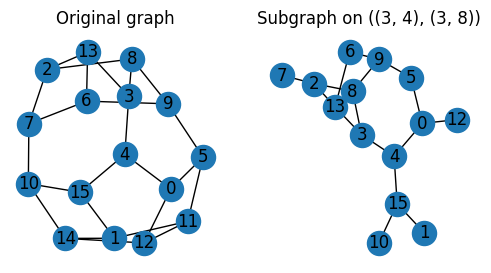

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))
plt.sca(axs[0])
nx.draw_kamada_kawai(G, with_labels=True)
plt.title(f'Original graph')
plt.sca(axs[1])
nx.draw_kamada_kawai(subgraph, with_labels=True)
plt.title(f'Subgraph on {edge_pair}')

### Manual computation of cost distribution

The code below calculates exact probabilities for each bitstring, then 
calculates the exact distribution of QAOA MaxCut for the fixed angle parameters.
This is then used to get exact variance and verify that tensor network calculations are correct

got probs
got costs


Text(0.5, 1.0, 'Cost distribution')

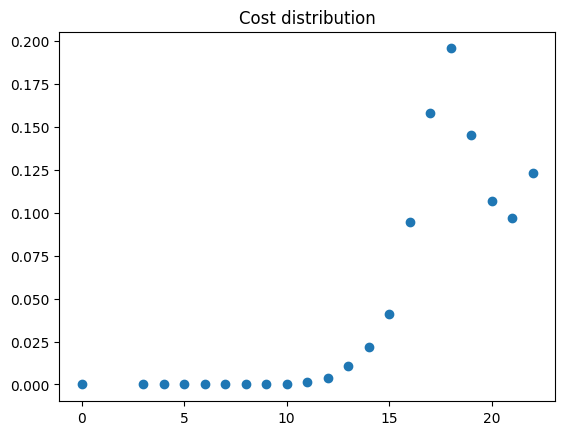

In [126]:
assert G.number_of_nodes()<20, "Too many nodes"
cost_dist = get_maxcut_cost_dist(G, p=p)
cost_dist

plt.scatter(cost_dist.keys(), cost_dist.values())
plt.title('Cost distribution')


In [127]:
def post_process_variance(E, linear, squared):
    cost = 1/2*(E - linear)
    cost2 = 1/4*(E*E - 2*E*linear + squared)
    return cost, cost2

def simulate_variance(G, p=4, pbar=True):
    gamma, beta = get_gb(p)
    sim = qtensor.QtreeSimulator()
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    squared = 0
    if pbar:
        outer_loop = tqdm(list(G.edges))
    else:
        outer_loop = G.edges
    for e1 in outer_loop:
        for e2 in G.edges:
            comp.energy_expectation_lightcone_squared(e1, e2)
            energy2 = sim.simulate_batch(comp.circuit, batch_vars=0)
            squared += energy2
    linear = 0
    for e in G.edges:
            comp.energy_expectation_lightcone(e)
            energy = sim.simulate_batch(comp.circuit, batch_vars=0)
            linear += energy
    E = G.number_of_edges()
    cost, cost2 = post_process_variance(E, linear, squared)
    print('linear', linear)
    print('squared', squared)
    print('cost', cost)
    print('cost2', cost2)
    return cost2 - cost*cost


In [128]:
var = simulate_variance(G, p=p)
print('Variance', var)

  0%|          | 0/24 [00:00<?, ?it/s]

linear [-12.9800425+1.38777878e-16j]
squared [188.30056406+5.71404652e-16j]
cost [18.49002125-6.9388939e-17j]
cost2 [346.835651-1.52248337e-15j]
Variance [4.9547652+1.04352254e-15j]


In [129]:
pdf = np.array(list(cost_dist.values()))
x = np.array(list(cost_dist.keys()))
Z = sum(pdf)
mean = sum(pdf*x)/Z
var_direct = sum(pdf*(mean-x)**2)/Z
var_direct

4.954753406172711

Verify that the exact variances using full statevector match with tensor network calculations

In [130]:
assert np.isclose(np.real(var), var_direct), "The two don't match!"
print("The two match!")

The two match!


## Large scale simulations

### First, estimate width of simulations to understand max size

In [137]:
def circ2tw(circ, opt: qtensor.optimisation.Optimizer):
    tn = qtensor.optimisation.QtreeTensorNet.from_qtree_gates(circ)
    opt.optimize(tn)
    return opt.treewidth
    
def estimate_variance_tw(G, p=4, ordering_algo='greedy', pbar=False):
    gamma, beta = get_gb(p)
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    widths = []
    if pbar:
        outer_loop = tqdm(list(G.edges))
    else:
        outer_loop = G.edges
    for e1 in outer_loop:
        for e2 in G.edges:
            comp.energy_expectation_lightcone_squared(e1, e2)
            tw = circ2tw(comp.circuit, opt)
            widths.append(tw)
    return widths

In [138]:
widths = estimate_variance_tw(G, p=p, pbar=True)

  0%|          | 0/24 [00:00<?, ?it/s]

Max width 15


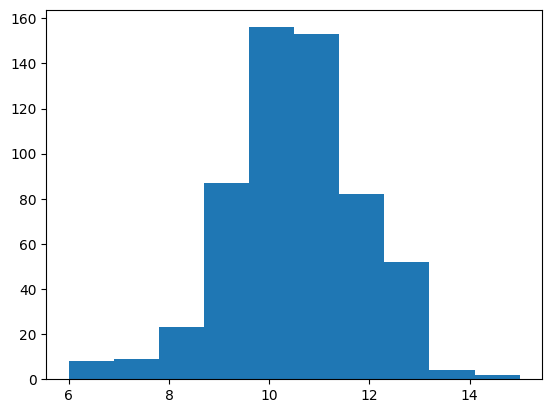

In [141]:
plt.hist(widths)
print("Max width", max(widths))

In [142]:
parallel = parallels.Ray(processes=55)

First try: parallelize over graphs. Limited capacity since we have few graphs and a lot of edge contributions

In [147]:
Ns = [20, 24]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit(N, p):
    G = nx.random_regular_graph(3, N, seed=10)
    return estimate_variance_tw(G, p=p)
args = dict_product(**params)

In [ ]:
data = parallel.starstarmap(unit, args)

In [153]:
max(sum(data, []))

31

Second try: parallelize over graphs edges

In [154]:

# parallelism at the level of individual graph

# -- Treewidth
def tw_parallel_unit(G, p, e1, ordering_algo='greedy'):
    gamma, beta = get_gb(p)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    widths = []
    for e2 in G.edges:
        comp.energy_expectation_lightcone_squared(e1, e2)
        tw = circ2tw(comp.circuit, opt)
        widths.append(tw)
    return widths
    
def estimate_variance_tw_parallel(G, parallel, p=4, ordering_algo='greedy'):
    args = dict_product(e1=list(G.edges), p=[p], G=[G], ordering_algo=[ordering_algo])
    widths_sq = parallel.starstarmap(tw_parallel_unit, args)
    return sum(widths_sq, [])

# -- Simulation
def variance_parallel_unit(G, p, e1, ordering_algo='greedy'):
    gamma, beta = get_gb(p)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    opt = qtensor.toolbox.get_ordering_algo(ordering_algo)
    sim = qtensor.QtreeSimulator(optimizer=opt)
    squared = 0
    for e2 in G.edges:
        comp.energy_expectation_lightcone_squared(e1, e2)
        energy2 = sim.simulate_batch(comp.circuit, batch_vars=0)
        squared += energy2
    return squared

    
def simulate_variance_parallel(G, parallel, p=4, ordering_algo='greedy'):
    args = dict_product(e1=list(G.edges), p=[p], G=[G], ordering_algo=[ordering_algo])
    squared_seq = parallel.starstarmap(variance_parallel_unit, args)
    squared = np.array(squared_seq).sum()

    # -- linear
    gamma, beta = get_gb(p)
    comp = QAOAComposerSquared(G, gamma=gamma, beta=beta)
    sim = qtensor.QtreeSimulator()
    linear = 0
    # this is usually much faster, so don't bother
    for e in G.edges:
        comp.energy_expectation_lightcone(e)
        energy = sim.simulate_batch(comp.circuit, batch_vars=0)
        linear += energy
    # -- linear
    E = G.number_of_edges()
    cost, cost2 = post_process_variance(E, linear, squared)
    return cost2 - cost*cost

In [155]:
widths = estimate_variance_tw_parallel(G, parallel, p=p)
var = simulate_variance_parallel(G, parallel, p=p)
var

array([4.9547652+1.04352254e-15j])

(array([  8.,   9.,  23.,  87., 156., 153.,  82.,  52.,   4.,   2.]),
 array([ 6. ,  6.9,  7.8,  8.7,  9.6, 10.5, 11.4, 12.3, 13.2, 14.1, 15. ]),
 <BarContainer object of 10 artists>)

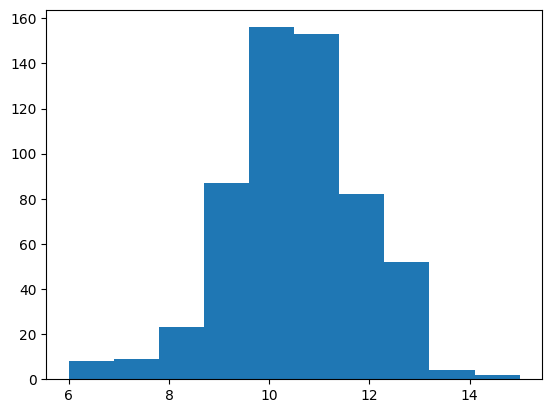

In [156]:
plt.hist(widths)

In [157]:
Ns = [20, 30, 40, 50]
ps = [2, 3, 4]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=10)
    return estimate_variance_tw_parallel(G, parallel, p=p)
args = dict_product(**params)

In [158]:
data = parallel.starstarmap(unit_parallel, args)

In [159]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys())
xwm = xarray.apply_ufunc(max, xwa, vectorize=True)

/tmp/ipykernel_78003/4048087232.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data).reshape(len(params['N']), -1)


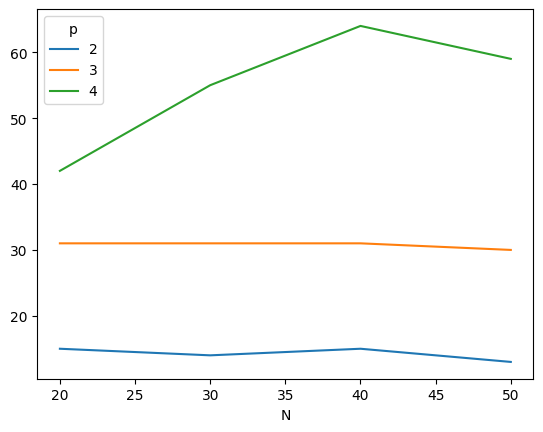

In [160]:
xwm.plot(x='N', hue='p')

p=4 is hard to simulate. We'll focus on p=2, 3. 

### Ordering algo
Changing ordering algorithm reduces memory requirement and speeds up computations, but can itself take time

In [163]:
Ns = [20, 30, 40, 50]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=10)
    return estimate_variance_tw_parallel(G, parallel, p=p, ordering_algo='rgreedy_0.03_10')
args = dict_product(**params)

In [164]:
data = parallel.starstarmap(unit_parallel, args)

In [165]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys())
xwm = xarray.apply_ufunc(max, xwa, vectorize=True)

/tmp/ipykernel_78003/4048087232.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array(data).reshape(len(params['N']), -1)


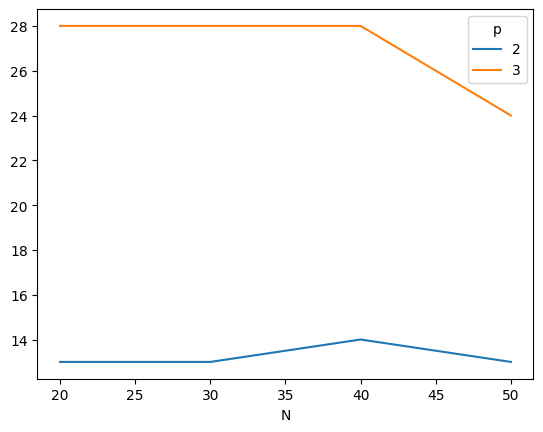

In [166]:
xwm.plot(x='N', hue='p')

### Calculate the width

In [167]:
Ns = [18, 20, 22, 24, 26, 28, 30, 36, 40, 46, 54]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=11)
    return simulate_variance_parallel(G, parallel, p=p, ordering_algo='rgreedy_0.03_10')
args = dict_product(**params)

In [168]:
# this takes ~30 minutes with 55 cores
data = parallel.starstarmap(unit_parallel, args)

In [169]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys()).real
xwr = np.sqrt(xwa)/xwa.N/3*2

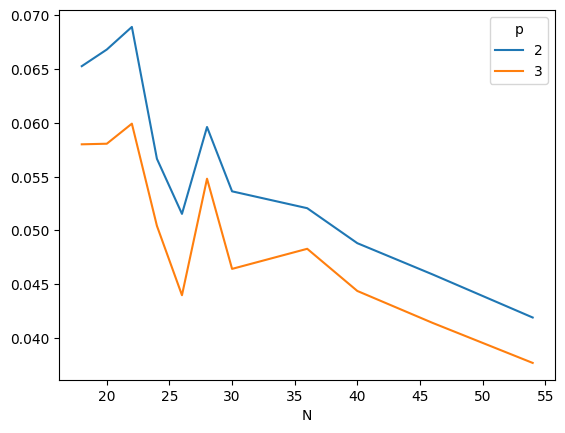

In [170]:
xwr.plot(x='N', hue='p')

In [171]:
xwa.to_netcdf('../qaoa_variance_exact_p23.nc')

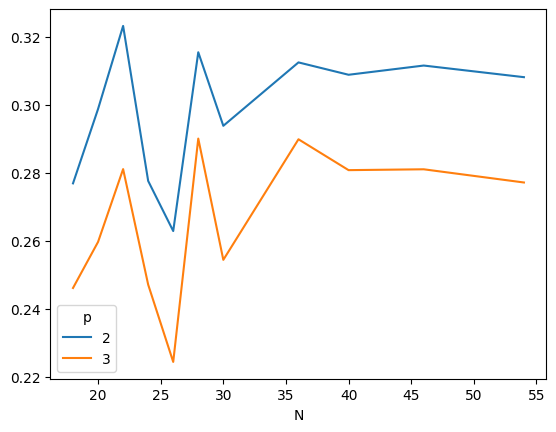

In [172]:
(xwr*np.sqrt(xwr.N)).plot(x='N', hue='p')

## SD for large N to compare with predictions

In [10]:
Ns = [256]#, 512, 1024]
ps = [2, 3]
params = dict(N=Ns, p=ps)
def unit_parallel(N, p):
    G = nx.random_regular_graph(3, N, seed=11)
    return simulate_variance_parallel(G, parallel, p=p, ordering_algo='rgreedy_0.03_10')
args = dict_product(**params)

In [ ]:
# this runs ~3 hours on 55 cores
data = parallel.starstarmap(unit_parallel, args)

In [ ]:
data = np.array(data).reshape(len(params['N']), -1)
xwa = xarray.DataArray(data, coords=params, dims=params.keys()).real

In [ ]:
xwa.to_netcdf('../qaoa_variance_exact_p23_N256.nc')

In [8]:
xwa = xarray.load_dataarray('../qaoa_variance_exact_p23_N256.nc')
# Convert variance to SD and normalize to cut fraction
xwr = np.sqrt(xwa)/xwa.N/3*2
xwr

<xarray.DataArray (N: 1, p: 2)>
array([[0.01915903, 0.01734625]])
Coordinates:
  * p        (p) int32 2 3
  * N        (N) int32 256

In [11]:
print("SD for N=256 and p=3", xwr.sel(p=3).data)

SD for N=256 and p=3 [0.01734625]


---